In [1]:
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

We are using sep as '\t' because it is tsv file. i.e tab seperated and not comma sepearted. Morever there are no column names; so we are providing two column names as well while creating the dataframe. As we can check from image below..

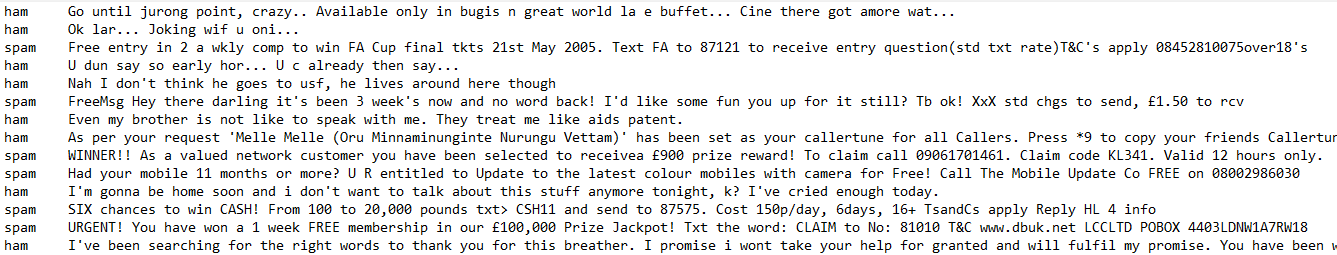

In [2]:
import pandas as pd
sms_data = pd.read_csv('/content/SMSSpamCollection', sep = '\t', names = ['spam/ham', 'mesage'])

In [3]:
sms_data.head()

,spam/ham,mesage
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


As we can see our data does not have missing values.

In [4]:
sms_data.isnull().sum()

spam/ham    0
mesage      0
dtype: int64

As we can see from below; our data is largely imbalanced hence we may get our predictioned inclined towards one category; so we need to balance this.

In [5]:
sms_data['spam/ham'].value_counts()

ham     4825
spam     747
Name: spam/ham, dtype: int64

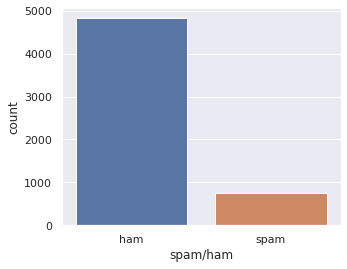

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.set_theme(style='darkgrid')
sns.countplot(x="spam/ham", data=sms_data)

Now applying lambda function to add another column in datfarame that has length of text messages.

In [7]:
def getLen(message):
  message = str(message)
  return len(message)

In [8]:
sms_data['length_of_message'] = sms_data.apply(lambda x : len(x['mesage']), axis=1)

In [9]:
sms_data.tail()

,spam/ham,mesage,length_of_message
5567,spam,This is the 2nd time we have tried 2 contact u...,160
5568,ham,Will ü b going to esplanade fr home?,36
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125
5571,ham,Rofl. Its true to its name,26


A plot of length of spam and not spam message

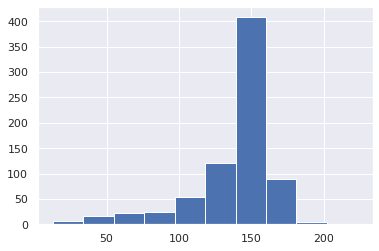

In [10]:
plt.hist(sms_data[sms_data['spam/ham'] == 'spam']['length_of_message'])
plt.show()

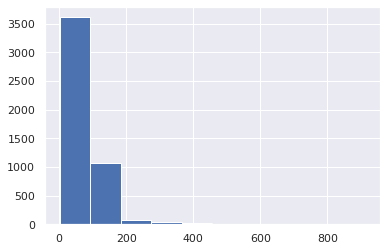

In [11]:
plt.hist(sms_data[sms_data['spam/ham'] == 'ham']['length_of_message'])
plt.show()

Now balancing the classes

In [12]:
sms_spam = sms_data[sms_data['spam/ham'] == 'spam']
sms_ham = sms_data[sms_data['spam/ham'] == 'ham']

In [13]:
sms_ham.tail()

,spam/ham,mesage,length_of_message
5565,ham,Huh y lei...,12
5568,ham,Will ü b going to esplanade fr home?,36
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125
5571,ham,Rofl. Its true to its name,26


In [14]:
sms_spam.head()

,spam/ham,mesage,length_of_message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
5,spam,FreeMsg Hey there darling it's been 3 week's n...,147
8,spam,WINNER!! As a valued network customer you have...,157
9,spam,Had your mobile 11 months or more? U R entitle...,154
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",136


In [15]:
print(sms_ham['mesage'].shape, sms_spam['mesage'].shape)

(4825,) (747,)


Now we'll randomly select rows and make size of not spam messages to spam messages.

In [16]:
sms_ham = sms_ham.sample(sms_spam['mesage'].shape[0])

In [17]:
sms_ham.head()

,spam/ham,mesage,length_of_message
4201,ham,I will come tomorrow di,23
822,ham,On the road so cant txt,23
3307,ham,HI DARLIN I FINISH AT 3 DO U 1 2 PICK ME UP OR...,93
3039,ham,You are not bothering me but you have to trust...,63
3887,ham,"Same, I'm at my great aunts anniversary party ...",63


As we can see above indexes are random; reseting index. (can be ignored though). We are using drop = True because if not previous index will be added as new coloumn.

In [18]:
sms_ham.reset_index(inplace=True, drop = True)

In [19]:
sms_ham.head()

,spam/ham,mesage,length_of_message
0,ham,I will come tomorrow di,23
1,ham,On the road so cant txt,23
2,ham,HI DARLIN I FINISH AT 3 DO U 1 2 PICK ME UP OR...,93
3,ham,You are not bothering me but you have to trust...,63
4,ham,"Same, I'm at my great aunts anniversary party ...",63


Combinig both the datasets.

In [20]:
final_sms_data = sms_ham.append(sms_spam, ignore_index=True)

In [21]:
len(final_sms_data)

1494

In [22]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [23]:
corpus = []

Removing special charcaters, stopwords and extra spaces and applying stemming.

In [26]:
for i in range(0, len(final_sms_data)):
  sms = re.sub('[^a-zA-Z]', ' ', final_sms_data['mesage'][i])
  sms = sms.lower()
  sms = sms.split()
  #stemming :
  sms = [ps.stem(word) for word in sms if not word in stopwords.words('english')]
  sms = ' '.join(sms)
  corpus.append(sms)

In [28]:
corpus[:7]

['come tomorrow di',
 'road cant txt',
 'hi darlin finish u pick meet text back number luv kate xxx',
 'bother trust answer pl',
 'great aunt anniversari parti tarpon spring',
 'lei',
 'ya knw u vl giv ok thank kano anyway enjoy wit ur famili wit st salari']

Creating Bag of words. 

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=2500) #if we simply run without providing max_features we will have a sparse matrix having columns equal to 3073 to represent each word.
#To make it more effective we will take top 2500 most frequently appearing words.
X = cv.fit_transform(corpus)

As we can see below, X is sparse matrix with 1494 rows and 2500 columns to represent each word. If we notice 1494*250  >>>  15066. So the data is stored in comressed form to save space.




In [33]:
X

<1494x2500 sparse matrix of type '<class 'numpy.int64'>'
	with 15066 stored elements in Compressed Sparse Row format>

Coverting X to array.

In [34]:
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [35]:
X.shape

(1494, 2500)

As we have text as category; so we need to convert it into numerical category, so the machine can understand it.

In [43]:
y = pd.get_dummies(final_sms_data['spam/ham'])
print(y.head(2)) # as we joined df in which non spam was at top.
print("\n")
print(y.tail(2))

   ham  spam
0    1     0
1    1     0


      ham  spam
1492    0     1
1493    0     1


As clear from above one of the column is completely unnecessary. As only one can be used to identify the category. So dropping one column.

In [44]:
y = y.drop('ham', axis=1)

In [47]:
y.tail()

,spam
1489,1
1490,1
1491,1
1492,1
1493,1


In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [52]:
print(X_train.shape, X_test.shape)

(1045, 2500) (449, 2500)


In [62]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train, y_train['spam'])
y_pred = model.predict(X_test)

In [64]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[214  13]
 [ 14 208]]


In [66]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9398663697104677

In [89]:
stopwords_list = stopwords.words('english')

Now creating a function and passing all the objects of lib that are required to do preprocessing.

In [101]:
def getPrediction(txt_msg, model, count_vectorizer, porter_stemmer, regular_exp, stopwords_list):
  #txt_msg_p = txt_msg
  txt_msg = re.sub('[^a-zA-Z]', ' ', txt_msg)
  txt_msg = txt_msg.lower()
  txt_msg = txt_msg.split()

  #txt_msg = list(txt_msg)
  #stemming :
  sms = [porter_stemmer.stem(word) for word in txt_msg if not word in stopwords_list]
  txt_msg = ' '.join(sms)
  #corpus.append(txt_msg)
  txt = []
  txt.append(txt_msg)
  txt_msg = count_vectorizer.transform(txt).toarray()
  prediction = model.predict(txt_msg)
  return prediction

array([0], dtype=uint8)

In [114]:
message = 'congrats your account is credited with 1 million dollars'

result = getPrediction(message, model, cv, ps, re, stopwords_list)
if(result == 1):
  print('Spam')
else:
  print('Not spam')

Spam
